In [1]:
import numpy as np
import pandas as pd
import os 
import sys
import torch

DATASETS = '../datasets/'

def read_file(dir_name):
    main_df = pd.DataFrame()
    directory = DATASETS + dir_name
    for filename in os.listdir(directory):
        data = np.load(os.path.join(directory, filename))
        data_dict = {}
        for keys in data.keys():
            data_dict[keys] = list(data[keys])
        df = pd.DataFrame.from_dict(data_dict)
        main_df = pd.concat([main_df, df])
    return main_df

In [2]:
data = []
for name in os.listdir("../datasets/mw"):
    inner_df = pd.DataFrame()
    if not (name.startswith('.')):
        dir_name = 'mw/'+name
        print(dir_name)
        df = read_file(dir_name)
        inner_df = pd.concat([inner_df, df])    
    data.append(inner_df)
data = np.array(data, dtype=object)


mw/cls_sweep-v2
mw/cls_push-v2
mw/cls_door-open-v2
mw/cls_peg-insert-side-v2
mw/cls_drawer-close-v2
mw/cls_basketball-v2
mw/cls_reach-v2
mw/cls_window-open-v2
mw/cls_pick-place-v2
mw/cls_button_press_topdown-v2


# MAIN CODE

In [12]:
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import warnings
import copy
import matplotlib.pyplot as plt
import random
warnings.filterwarnings('ignore')

class Model(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size = 2750):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.out = nn.Linear(hidden_size3, 1)

    def forward(self, x):
        # print(x.shape)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.tanh(self.out(x))
        return x


class PreferenceMAML:
    def __init__(
        self,
        ml10,
        input_size,
        hidden_size1,
        hidden_size2,
        outer_lr = 0.0001,
        inner_lr = 0.001,
        num_support=10,
        num_query=10,
        num_inner_steps=5,
        k = 25,
        num_tasks = 10,
        episode_per_task = 1250,
        output_size = 2750,
        **kwargs,
    ):
        self.ml10 = ml10
        self.reward_criterion =  nn.BCELoss()
        self.num_support = num_support
        self.num_query = num_query
        self.num_inner_steps = num_inner_steps
        self.inner_lr = inner_lr
        self.outer_lr = outer_lr
        self.k = k
        self.num_tasks = num_tasks
        self.episode_per_task = episode_per_task
        self.num_segments = None
        self.model = Model(input_size, hidden_size1, hidden_size2, output_size)

    def construct_episodes(self, ml10):
        # episodes - n (tasks) x num_episode (each npz file)  , each cell is a dataframe of the episode 
        self.episodes = []
        for task in ml10:
            if(len(task)==0):
                continue
            task_episodes=[]
            row_index = task[task['done'] == True].index.tolist()
            prev=0
            for x in row_index:
                task_episodes.append(task[prev:x+1])
                prev=x+1
            task_episodes = np.array(task_episodes,dtype=object)
            self.episodes.append(task_episodes)
        self.episodes = np.array(self.episodes,dtype=object)
        # return episodes

    def form_sigma_groups(self, episode):
        #num_segments = int(episode.shape[0] / self.k)
        split_indices = np.arange(self.k, episode.shape[0], self.k)
        # print(num_segments)
        if len(split_indices) != 0:
            l_segment = np.array_split(episode.iloc[::-1][:(self.k*(episode.shape[0] // self.k))], split_indices)
            for i in range(len(l_segment)):
                l_segment[i] = l_segment[i].iloc[::-1]
            if(len(l_segment[-1])<25):
                l_segment=l_segment[:-1]
            return l_segment
        else:
            return None

    def compare_probabilities(self, sigma1, sigma2):
        exp_sum_rewards_sigma1 = np.exp(sum(row['reward'] for row in sigma1))
        exp_sum_rewards_sigma2 = np.exp(sum(row['reward'] for row in sigma2))
        prob = exp_sum_rewards_sigma1 / (exp_sum_rewards_sigma1 + exp_sum_rewards_sigma2)
        return [0] if prob > 0.5 else [1]

    def prepare_data(self):
        X = []
        y = []
        episodes = self.episodes
        # sigmas = self.form_sigma_groups(episodes, k)
        sigmas = []
        for task in episodes:
            sigma = []
            for episode in task:
                segment = self.form_sigma_groups(episode)
                # print(len(segment))
                if segment is not None:
                    sigma.append(segment)
            # sigma = [self.form_sigma_groups(episode, k) for episode in task]
            sigmas.append(sigma)
        sigmas = np.array(sigmas, dtype=object)
        all_lengths = [len(episode) for task in sigmas for episode in task]

        self.num_segments = min(all_lengths)
        if(self.num_segments<3):
            self.num_segments=3
        
        for task in sigmas:
            task_list=[]
            for episode in task:
                ep_list=[]
                if(len(episode)<self.num_segments):
                    continue
                for i in range(self.num_segments):
                    y.append(episode[i]["reward"])
                    ep_list.append(episode[i].drop('reward', axis=1))
                
                task_list.append(ep_list)
            task_list=np.array(task_list, dtype=object).reshape(-1,1) # convert row vector to col vector
            X.append(task_list)
        X_new=[]
        task_counter = []
        for task in X:
            counter = 0
            for i in range(0,len(task),4):
                X_new.append(np.concatenate((task[i][0], task[i+1][0])))
                counter += 1
            task_counter.append(counter)

        X = np.array(X_new, dtype=object)
        task_counts = np.array(task_counter, dtype=object)
        y=np.array(y,dtype=object)
        y=y.flatten()
        #X=X.reshape(-1,1) # convert row vector to col vector


        # All row vectors now, just transpose to make column vectors
        

            # sigmas = self.form_sigma_groups(episode, k)
            # for _ in range(len(sigmas)):
            #     sigma1 = sigmas[_][0]
            #     sigma2 = sigmas[_][1]

            #     obs_action_sigma1 = []
            #     for row in sigma1:
            #         obs_action = list(row['obs']) + list(row['action']) 
            #         obs_action_sigma1.append(obs_action)

            #     obs_action_sigma2 = []
            #     for row in sigma2:
            #         obs_action = list(row['obs']) + list(row['action'])  
            #         obs_action_sigma2.append(obs_action)

            #     if len(obs_action_sigma1) > len(obs_action_sigma2):
            #         obs_action_sigma1 = obs_action_sigma1[1:]
            #     elif len(obs_action_sigma1) < len(obs_action_sigma2):
            #         obs_action_sigma2 = obs_action_sigma2[1:]
            #     else:
            #         continue

            #     X.append(np.concatenate((obs_action_sigma1, obs_action_sigma2), axis=1))
            #     y.append(self.compare_probabilities(sigma1, sigma2))

        return X, y, task_counts
    
    def batchify(self, X, y, task_lengths, task_no, num=110):
        # print(task_no)
        if task_no == 0:
            task_beg = 0  
            task_end = task_lengths[0]
        else:    
            task_beg = np.sum(task_lengths[0:task_no])    
            task_end = np.sum(task_lengths[0:task_no+1])
        rand = random.sample(range(0,400), 110)
        X_task = X[task_beg:task_end]
        y_task = y[task_beg:task_end]
        X_random = []
        y_random = []
        for r in rand:
            X_random.append(X_task[r*25 : r*25+25])
            y_random.append(y_task[r*25 : r*25+25])
        X_random = np.array(X_random, dtype=np.float32)
        y_random = np.array(y_random, dtype=np.float32)
        return X_random.reshape(2750,43), y_random.reshape(2750,)
    
    
    def train(self, X, y, task_lengths, num_epochs):
        optimizer = optim.SGD(self.model.parameters(), lr=self.outer_lr)
        plt_x = np.arange(0, num_epochs)
        plt_y = np.zeros(num_epochs)
        for epoch in tqdm(range(num_epochs)):
            optimizer.zero_grad()
            loss = 0
            for t in range(self.num_tasks):
                # print(t)
                X_b, y_b = self.batchify(X, y, task_lengths, t)
                model_t = copy.deepcopy(self.model)
                model_t = self._inner_loop(model_t, X_b, y_b)
                loss += self._compute_loss(model_t, X_b, y_b)

                # print(f"Epoch {epoch+1}/{num_epochs} - Task {t+1}/{self.num_tasks}")
            out = loss
            # for i in range(1, len(loss)):
            #     out += loss[i]
            
            plt_y[epoch] = out
            if epoch % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss}')
                plt.plot(plt_x[:epoch], plt_y[:epoch])
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.show()
            
            print(out)
            out.backward()
            optimizer.step()
            

            

    # def _train_step(self, X, y):
    #     self.optim.zero_grad()
    #     loss = self._outer_step(X, y)
    #     loss.backward()
    #     self.optim.step()
    #     return loss.item()

    # def _outer_step(self, X, y):
    #     outer_losses = []
    #     for i in tqdm(range(len(X))):
    #         if len(X[i])>self.num_support:
    #             support_X, support_y, query_X, query_y = self._split_support_query(X[i], y[i])
    #             # Inner loop (adaptation)
    #             adapted_model = self._inner_loop(support_X, support_y)
    #             # Compute loss using the adapted model on query set
    #             query_loss = self._compute_loss(adapted_model, query_X, query_y)
    #             outer_losses.append(query_loss)
    #     return torch.mean(torch.stack(outer_losses))

    def _inner_loop(self, model, X, y):
        loss = self._compute_loss(model, X, y)
        opt = optim.SGD(model.parameters(), lr=self.inner_lr)
        # print(loss)
        opt.zero_grad()
        loss.backward()
        opt.step()

        return model
    '''
    R_E = 
    [
        [
            sigma_s1^E1, ..., sigma_s#^E1
        ],
        [
            sigma_s1^E2, ..., sigma_s#^E2
        ], ...,
        [
            sigma_s1^EN, ..., sigma_s#^EN
        ]
    ]
    '''
    #self.k = segment lenght
    def _compute_loss(self, model, X, y):
        # print(X, y, X.shape, y.shape)
        X_tensor = torch.from_numpy(X)
        y_tensor = torch.from_numpy(y)  
        output_reward = model(X_tensor)
        N_o, _ = output_reward.shape
        # print(output_reward.shape)
        x =  y_tensor.shape[0]
        N = x//self.k
        out_mat = np.zeros((N, 1))
        y_mat = np.zeros((N, 1))

        for i in range(N):
            # print(torch.sum(output_reward[i*self.k:(i+1)*self.k]).detach().numpy())
            out_mat[i, :] = torch.sum(output_reward[i*self.k:(i+1)*self.k]).detach().numpy()
            y_mat[i, :] = torch.sum(y_tensor[i*self.k:(i+1)*self.k]).detach().numpy()

        # print("Ouptut: ", out_mat)
        # print("Y: ",y_mat)
        loss = 0
        criterion = nn.CrossEntropyLoss()
        out_mat = np.exp(out_mat)
        out_logit = []
        out_y = []
        for i in range(N):
            sig_1 = out_mat[i, 0]
            y_1 = y_mat[i, 0]
            for j in range(i+1, N):
                sig_2 = out_mat[j, 0]
                y_2 = y_mat[j, 0]
                y_lab = 0.0
                if y_1 > y_2:
                    y_lab = 0.0
                else:
                    y_lab = 1.0

                logit = sig_1/ (sig_1 + sig_2)
                out_logit.append([logit, 1 - logit])
                out_y.append([0.0, 1.0])
                # out_jk = criterion(torch.tensor([logit, 1-logit], requires_grad=True), torch.tensor([0.0, 1.0], requires_grad= True))
                # print("logit:", logit)
                # print("y_lab:", y_lab)
                # print("out_jk:", out_jk)
                # loss += out_jk
                # if (y_1 >= y_2):
                #     loss.append(out_jk)
                # else:
                #     loss.append(1 - out_jk)
        # output = loss[0]
        loss = criterion(torch.tensor(out_logit, requires_grad=True), torch.tensor(out_y, requires_grad= True))
        # for i in range(1, len(loss)):
        #     output += loss[i]
        # print("Loss: ", loss)
        return loss


################################################################################################
################################################################################################
################################################################################################

ml10 = data.copy()  
input_size = 43  # Assuming obs has 39 numbers and action has 4 numbers * 2 for pair of sigmas
hidden_size1 = 256
hidden_size2 = 256
hidden_size3 = 256
# hidden_size3 = 1024
# hidden_size4 = 2075

output_size = 1
num_epochs = 5
outer_lr = 0.0001

model = PreferenceMAML(ml10, input_size, hidden_size1, hidden_size2, hidden_size3)
# model.setup_optimizers(optim.Adam, {"lr": outer_lr})

model.construct_episodes(ml10)
print('Preparing Data.')



Preparing Data.


In [4]:
X, y, task_lengths = model.prepare_data()
print('Data Preparation Done.\n')

# # Train the model
# for epoch in range(num_epochs):
#     print(f'\nBeginning Training - Epoch [{epoch+1}/{num_epochs}]')
#     loss = model._train_step(X, y)
#     print(f"Epoch {epoch+1}, Loss: {loss}")

Data Preparation Done.



  0%|                                                 | 0/10000 [00:00<?, ?it/s]

Epoch 1/10000, Loss: 7.043987395428612


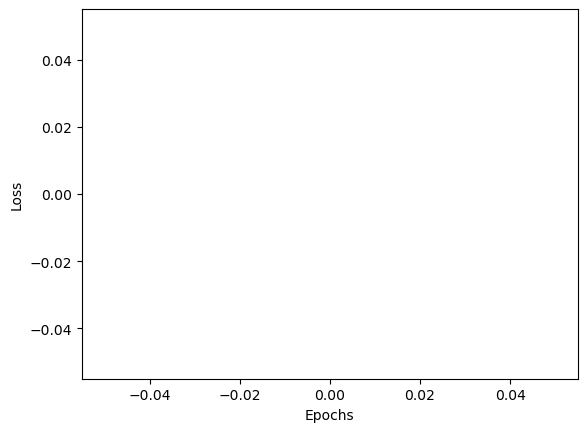

  0%|                                       | 1/10000 [00:01<2:57:06,  1.06s/it]

tensor(7.0440, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                       | 2/10000 [00:02<3:03:48,  1.10s/it]

tensor(7.0058, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                       | 3/10000 [00:03<3:31:04,  1.27s/it]

tensor(6.9901, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                       | 4/10000 [00:04<3:36:02,  1.30s/it]

tensor(6.9821, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                       | 5/10000 [00:05<3:06:37,  1.12s/it]

tensor(6.9623, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                       | 6/10000 [00:07<3:11:06,  1.15s/it]

tensor(6.9928, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                       | 7/10000 [00:07<2:57:39,  1.07s/it]

tensor(7.0156, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                       | 8/10000 [00:09<3:01:43,  1.09s/it]

tensor(6.9925, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                       | 9/10000 [00:09<2:51:02,  1.03s/it]

tensor(6.9993, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 10/10000 [00:11<3:05:59,  1.12s/it]

tensor(6.9627, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 11/10000, Loss: 7.035027485707345


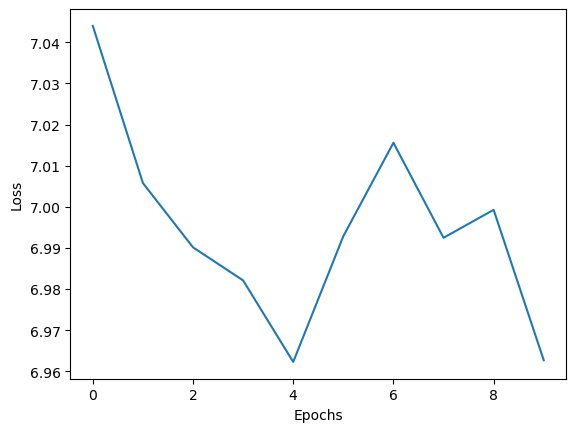

  0%|                                      | 11/10000 [00:12<3:14:46,  1.17s/it]

tensor(7.0350, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 12/10000 [00:13<3:02:06,  1.09s/it]

tensor(6.9960, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 13/10000 [00:14<3:02:22,  1.10s/it]

tensor(6.9950, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 14/10000 [00:15<2:51:59,  1.03s/it]

tensor(6.9446, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 15/10000 [00:16<2:57:27,  1.07s/it]

tensor(6.9533, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 16/10000 [00:17<2:48:04,  1.01s/it]

tensor(6.9280, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 17/10000 [00:19<3:16:12,  1.18s/it]

tensor(6.9947, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 18/10000 [00:20<3:22:37,  1.22s/it]

tensor(6.9833, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 19/10000 [00:21<3:07:33,  1.13s/it]

tensor(6.9692, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 20/10000 [00:23<3:38:01,  1.31s/it]

tensor(6.9668, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 21/10000, Loss: 6.971479619824064


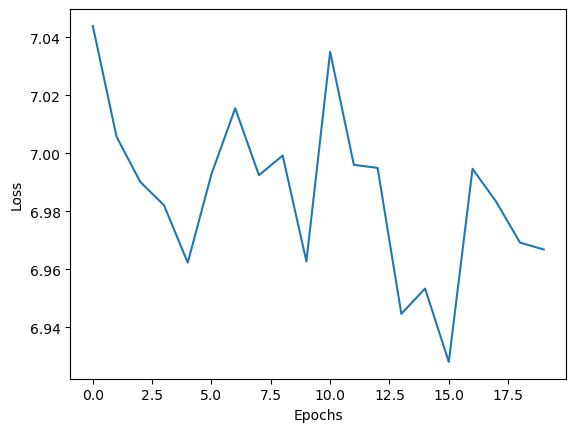

  0%|                                      | 21/10000 [00:24<3:33:17,  1.28s/it]

tensor(6.9715, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 22/10000 [00:25<3:30:45,  1.27s/it]

tensor(7.0286, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 23/10000 [00:26<3:28:23,  1.25s/it]

tensor(6.9846, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 24/10000 [00:27<3:08:17,  1.13s/it]

tensor(6.9400, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 25/10000 [00:28<3:08:57,  1.14s/it]

tensor(7.0173, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 26/10000 [00:29<2:56:50,  1.06s/it]

tensor(6.9680, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 27/10000 [00:30<2:59:56,  1.08s/it]

tensor(7.0049, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 28/10000 [00:31<2:51:21,  1.03s/it]

tensor(6.9616, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 29/10000 [00:32<2:59:27,  1.08s/it]

tensor(6.9562, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 30/10000 [00:33<3:04:55,  1.11s/it]

tensor(6.9456, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 31/10000, Loss: 6.996037961803623


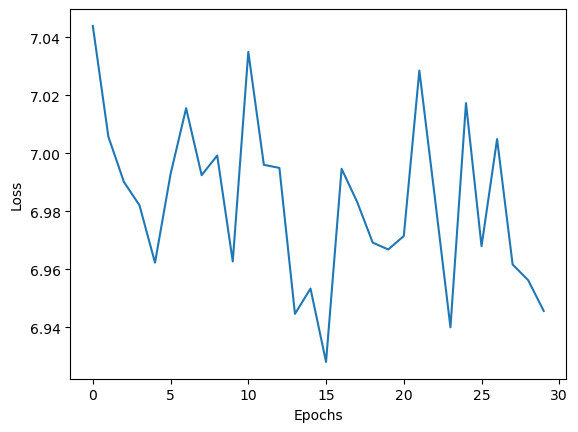

  0%|                                      | 31/10000 [00:35<3:06:58,  1.13s/it]

tensor(6.9960, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|                                      | 32/10000 [00:36<3:16:22,  1.18s/it]

tensor(7.0061, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 33/10000 [00:37<3:04:14,  1.11s/it]

tensor(6.9835, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 34/10000 [00:38<3:07:01,  1.13s/it]

tensor(6.9800, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 35/10000 [00:39<2:58:39,  1.08s/it]

tensor(6.9650, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 36/10000 [00:40<3:04:19,  1.11s/it]

tensor(7.0059, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 37/10000 [00:41<3:12:37,  1.16s/it]

tensor(6.9967, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 38/10000 [00:43<3:31:03,  1.27s/it]

tensor(6.9988, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 39/10000 [00:44<3:28:36,  1.26s/it]

tensor(6.9833, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 40/10000 [00:45<3:13:39,  1.17s/it]

tensor(7.0007, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 41/10000, Loss: 6.956411544981346


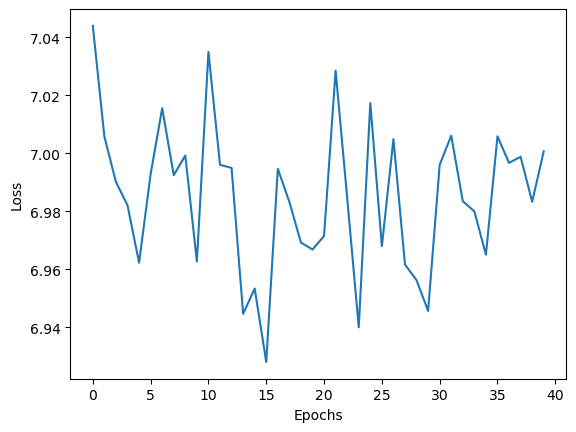

  0%|▏                                     | 41/10000 [00:46<3:20:05,  1.21s/it]

tensor(6.9564, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 42/10000 [00:47<3:07:15,  1.13s/it]

tensor(6.9802, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 43/10000 [00:49<3:10:57,  1.15s/it]

tensor(6.9624, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 44/10000 [00:50<3:14:06,  1.17s/it]

tensor(7.0110, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 45/10000 [00:51<3:01:06,  1.09s/it]

tensor(6.9441, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 46/10000 [00:52<3:24:52,  1.23s/it]

tensor(7.0285, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 47/10000 [00:53<3:08:42,  1.14s/it]

tensor(6.9518, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 48/10000 [00:54<3:09:33,  1.14s/it]

tensor(6.9874, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 49/10000 [00:55<2:58:02,  1.07s/it]

tensor(6.9586, dtype=torch.float64, grad_fn=<AddBackward0>)


  0%|▏                                     | 50/10000 [00:57<3:04:48,  1.11s/it]

tensor(7.0090, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 51/10000, Loss: 7.002626156413768


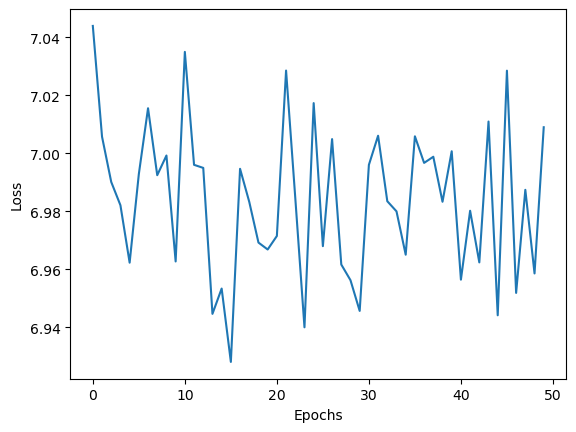

  1%|▏                                     | 51/10000 [00:58<3:13:23,  1.17s/it]

tensor(7.0026, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▏                                     | 52/10000 [00:59<3:02:39,  1.10s/it]

tensor(6.9879, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▏                                     | 53/10000 [01:00<3:06:12,  1.12s/it]

tensor(7.0133, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▏                                     | 54/10000 [01:01<2:57:45,  1.07s/it]

tensor(6.9372, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▏                                     | 55/10000 [01:02<3:10:51,  1.15s/it]

tensor(6.9792, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▏                                     | 56/10000 [01:03<3:00:39,  1.09s/it]

tensor(7.0037, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▏                                     | 57/10000 [01:04<3:09:24,  1.14s/it]

tensor(6.9955, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▏                                     | 58/10000 [01:06<3:14:48,  1.18s/it]

tensor(7.0127, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▏                                     | 59/10000 [01:07<3:02:17,  1.10s/it]

tensor(6.9939, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▏                                     | 60/10000 [01:08<3:16:56,  1.19s/it]

tensor(6.9920, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 61/10000, Loss: 6.99802660891827


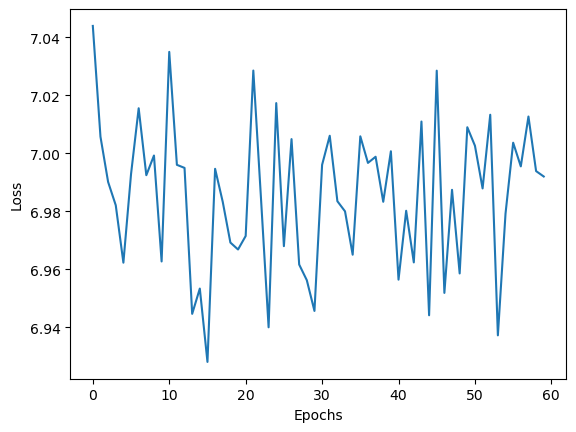

  1%|▏                                     | 61/10000 [01:09<3:10:00,  1.15s/it]

tensor(6.9980, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▏                                     | 62/10000 [01:10<3:24:04,  1.23s/it]

tensor(6.9701, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▏                                     | 63/10000 [01:12<3:23:24,  1.23s/it]

tensor(6.9500, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▏                                     | 64/10000 [01:13<3:05:56,  1.12s/it]

tensor(6.9747, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▏                                     | 65/10000 [01:14<3:07:28,  1.13s/it]

tensor(6.9919, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 66/10000 [01:15<2:58:45,  1.08s/it]

tensor(6.9768, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 67/10000 [01:16<3:04:06,  1.11s/it]

tensor(6.9434, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 68/10000 [01:17<2:53:31,  1.05s/it]

tensor(6.9749, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 69/10000 [01:18<3:00:54,  1.09s/it]

tensor(6.9597, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 70/10000 [01:19<3:09:30,  1.15s/it]

tensor(6.9614, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 71/10000, Loss: 6.975915641395885


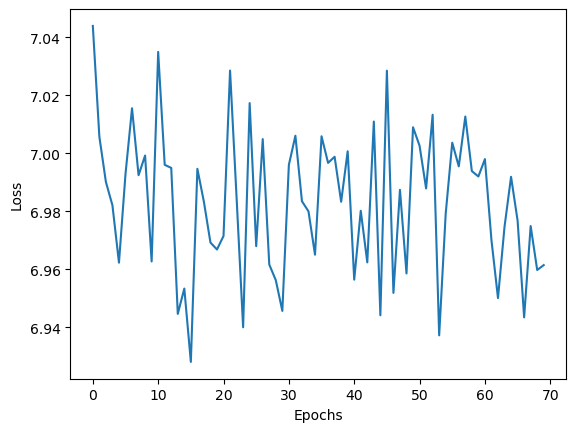

  1%|▎                                     | 71/10000 [01:20<3:10:18,  1.15s/it]

tensor(6.9759, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 72/10000 [01:22<3:10:41,  1.15s/it]

tensor(6.9710, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 73/10000 [01:23<3:00:27,  1.09s/it]

tensor(6.9940, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 74/10000 [01:24<3:11:32,  1.16s/it]

tensor(6.9883, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 75/10000 [01:25<2:59:43,  1.09s/it]

tensor(7.0018, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 76/10000 [01:26<3:05:12,  1.12s/it]

tensor(6.9863, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 77/10000 [01:27<3:09:10,  1.14s/it]

tensor(6.9974, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 78/10000 [01:28<3:04:56,  1.12s/it]

tensor(6.9698, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 79/10000 [01:29<3:05:30,  1.12s/it]

tensor(7.0118, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 80/10000 [01:30<2:55:58,  1.06s/it]

tensor(6.9644, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 81/10000, Loss: 6.9827635727675474


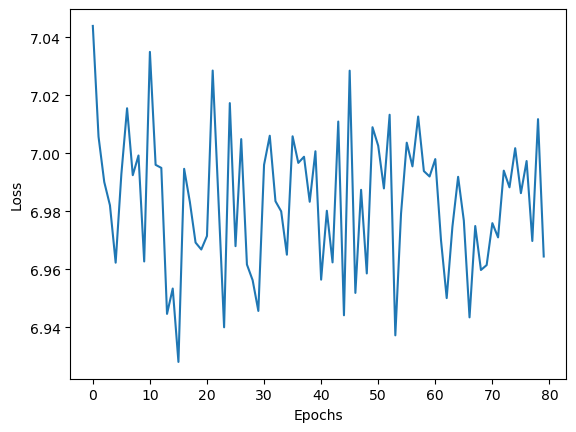

  1%|▎                                     | 81/10000 [01:32<3:06:43,  1.13s/it]

tensor(6.9828, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 82/10000 [01:32<2:55:43,  1.06s/it]

tensor(6.9813, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 83/10000 [01:34<3:04:08,  1.11s/it]

tensor(6.9888, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 84/10000 [01:35<3:07:23,  1.13s/it]

tensor(6.9211, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 85/10000 [01:36<3:03:29,  1.11s/it]

tensor(7.0078, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 86/10000 [01:37<3:12:18,  1.16s/it]

tensor(6.9984, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 87/10000 [01:39<3:28:00,  1.26s/it]

tensor(6.9754, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 88/10000 [01:41<4:01:43,  1.46s/it]

tensor(6.9737, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 89/10000 [01:42<3:48:21,  1.38s/it]

tensor(6.9591, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 90/10000 [01:44<4:29:54,  1.63s/it]

tensor(7.0457, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 91/10000, Loss: 6.949573705605065


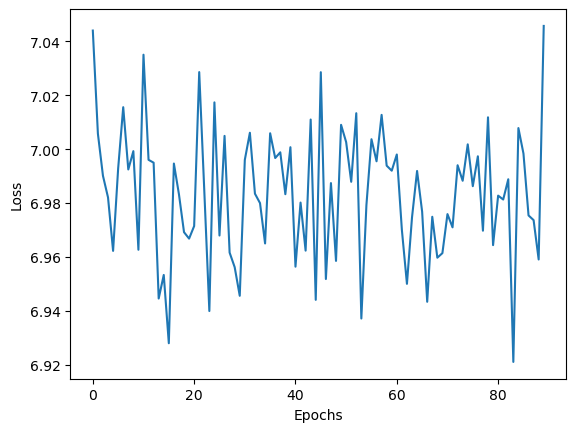

  1%|▎                                     | 91/10000 [01:46<4:31:02,  1.64s/it]

tensor(6.9496, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 92/10000 [01:47<4:30:32,  1.64s/it]

tensor(7.0334, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 93/10000 [01:49<4:40:19,  1.70s/it]

tensor(6.9625, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 94/10000 [01:50<4:07:03,  1.50s/it]

tensor(6.9775, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 95/10000 [01:52<4:06:46,  1.49s/it]

tensor(6.9761, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 96/10000 [01:53<3:47:10,  1.38s/it]

tensor(6.9726, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 97/10000 [01:55<4:13:17,  1.53s/it]

tensor(6.9950, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                     | 98/10000 [01:57<5:15:10,  1.91s/it]

tensor(7.0207, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                     | 99/10000 [01:59<4:40:48,  1.70s/it]

tensor(7.0038, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▎                                    | 100/10000 [02:01<5:08:52,  1.87s/it]

tensor(7.0080, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 101/10000, Loss: 7.015686812401632


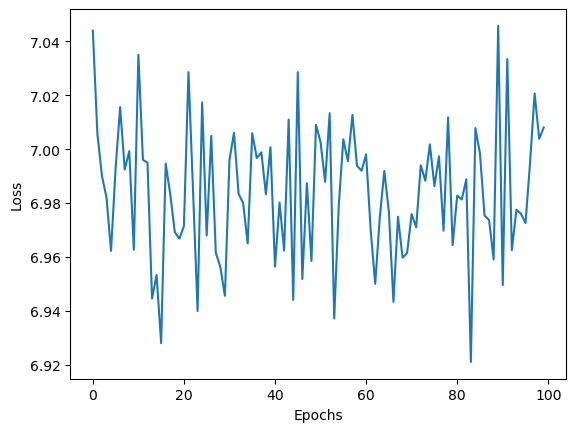

  1%|▎                                    | 101/10000 [02:02<4:43:25,  1.72s/it]

tensor(7.0157, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 102/10000 [02:04<4:41:22,  1.71s/it]

tensor(6.9750, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 103/10000 [02:05<4:09:04,  1.51s/it]

tensor(6.9834, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 104/10000 [02:06<4:03:27,  1.48s/it]

tensor(7.0321, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 105/10000 [02:08<3:53:00,  1.41s/it]

tensor(6.9781, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 106/10000 [02:09<3:42:42,  1.35s/it]

tensor(6.9820, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 107/10000 [02:10<3:41:30,  1.34s/it]

tensor(6.9632, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 108/10000 [02:12<3:55:47,  1.43s/it]

tensor(7.0020, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 109/10000 [02:14<4:36:31,  1.68s/it]

tensor(6.9728, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 110/10000 [02:15<4:15:27,  1.55s/it]

tensor(6.9706, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 111/10000, Loss: 7.0243467928622305


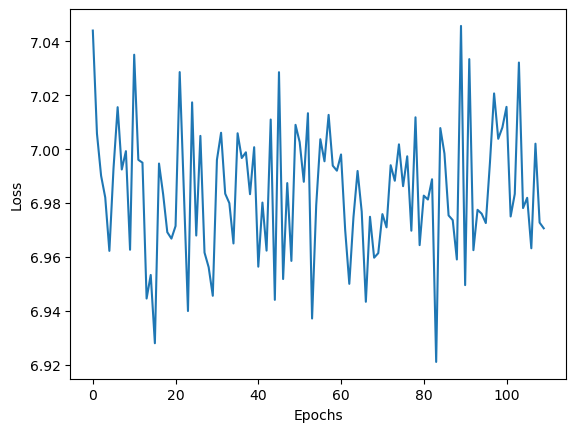

  1%|▍                                    | 111/10000 [02:17<4:18:26,  1.57s/it]

tensor(7.0243, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 112/10000 [02:19<4:20:48,  1.58s/it]

tensor(7.0151, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 113/10000 [02:20<4:02:26,  1.47s/it]

tensor(6.9948, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 114/10000 [02:22<4:18:13,  1.57s/it]

tensor(6.9262, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 115/10000 [02:23<4:12:26,  1.53s/it]

tensor(6.9817, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 116/10000 [02:25<4:47:37,  1.75s/it]

tensor(7.0420, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 117/10000 [02:26<4:17:42,  1.56s/it]

tensor(6.9407, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 118/10000 [02:28<4:11:01,  1.52s/it]

tensor(6.9817, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 119/10000 [02:29<3:54:28,  1.42s/it]

tensor(6.9666, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 120/10000 [02:30<3:29:17,  1.27s/it]

tensor(6.9838, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 121/10000, Loss: 7.01233441216093


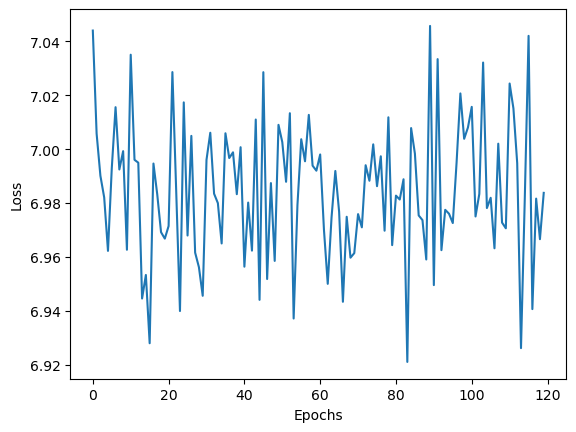

tensor(7.0123, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 122/10000 [02:32<3:21:40,  1.23s/it]

tensor(6.9444, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 123/10000 [02:34<3:19:31,  1.21s/it]

tensor(6.9372, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 124/10000 [02:35<3:19:15,  1.21s/it]

tensor(7.0047, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 125/10000 [02:36<3:03:18,  1.11s/it]

tensor(6.9728, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 126/10000 [02:37<3:06:03,  1.13s/it]

tensor(7.0029, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 127/10000 [02:38<2:56:20,  1.07s/it]

tensor(6.9613, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 128/10000 [02:39<3:00:03,  1.09s/it]

tensor(6.9736, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 129/10000 [02:40<3:02:29,  1.11s/it]

tensor(6.9865, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 130/10000 [02:41<3:05:59,  1.13s/it]

tensor(6.9665, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 131/10000, Loss: 7.000872402317244


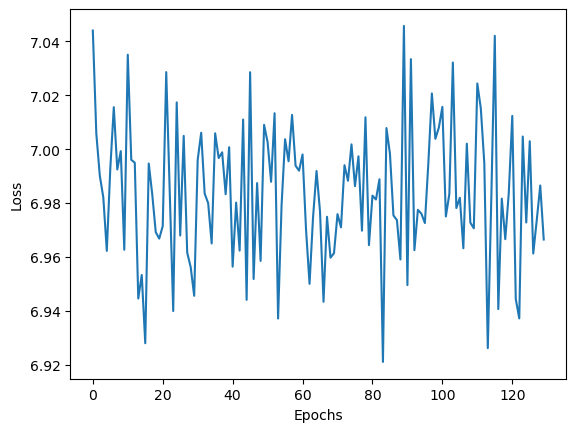

  1%|▍                                    | 131/10000 [02:43<3:15:06,  1.19s/it]

tensor(7.0009, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 132/10000 [02:44<3:10:22,  1.16s/it]

tensor(7.0141, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 133/10000 [02:45<3:15:42,  1.19s/it]

tensor(6.9554, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 134/10000 [02:46<3:09:17,  1.15s/it]

tensor(6.9264, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▍                                    | 135/10000 [02:47<3:08:48,  1.15s/it]

tensor(6.9857, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▌                                    | 136/10000 [02:48<2:57:31,  1.08s/it]

tensor(6.9091, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▌                                    | 137/10000 [02:49<3:03:12,  1.11s/it]

tensor(6.9542, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▌                                    | 138/10000 [02:50<3:06:51,  1.14s/it]

tensor(6.9516, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▌                                    | 139/10000 [02:51<2:54:11,  1.06s/it]

tensor(6.9992, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▌                                    | 140/10000 [02:52<2:57:29,  1.08s/it]

tensor(6.9925, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 141/10000, Loss: 6.987415548430331


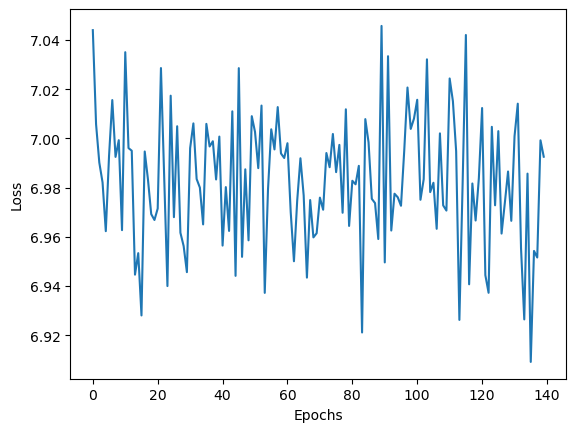

  1%|▌                                    | 141/10000 [02:54<3:11:10,  1.16s/it]

tensor(6.9874, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▌                                    | 142/10000 [02:55<3:19:04,  1.21s/it]

tensor(6.9505, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▌                                    | 143/10000 [02:57<3:39:33,  1.34s/it]

tensor(7.0035, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▌                                    | 144/10000 [02:58<3:16:34,  1.20s/it]

tensor(6.9676, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▌                                    | 145/10000 [02:59<3:15:58,  1.19s/it]

tensor(6.9706, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▌                                    | 146/10000 [03:00<3:11:26,  1.17s/it]

tensor(7.0033, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▌                                    | 147/10000 [03:01<3:11:18,  1.16s/it]

tensor(6.9441, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▌                                    | 148/10000 [03:02<2:59:04,  1.09s/it]

tensor(6.9772, dtype=torch.float64, grad_fn=<AddBackward0>)


  1%|▌                                    | 149/10000 [03:03<3:04:18,  1.12s/it]

tensor(6.9773, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 150/10000 [03:05<3:19:10,  1.21s/it]

tensor(6.9922, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 151/10000, Loss: 7.02984528269169


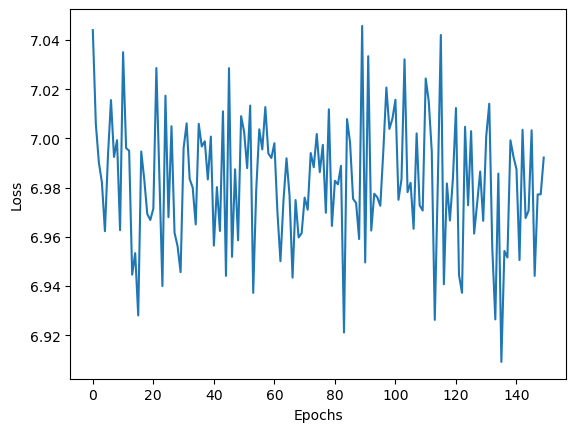

  2%|▌                                    | 151/10000 [03:06<3:08:40,  1.15s/it]

tensor(7.0298, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 152/10000 [03:07<3:13:07,  1.18s/it]

tensor(6.9766, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 153/10000 [03:08<3:04:20,  1.12s/it]

tensor(6.9390, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 154/10000 [03:09<3:05:53,  1.13s/it]

tensor(6.9764, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 155/10000 [03:10<2:58:59,  1.09s/it]

tensor(6.9735, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 156/10000 [03:11<3:04:32,  1.12s/it]

tensor(7.0351, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 157/10000 [03:13<3:19:25,  1.22s/it]

tensor(6.9788, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 158/10000 [03:14<3:02:33,  1.11s/it]

tensor(7.0199, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 159/10000 [03:15<3:05:26,  1.13s/it]

tensor(6.9762, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 160/10000 [03:16<3:01:48,  1.11s/it]

tensor(7.0029, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 161/10000, Loss: 7.014302643425369


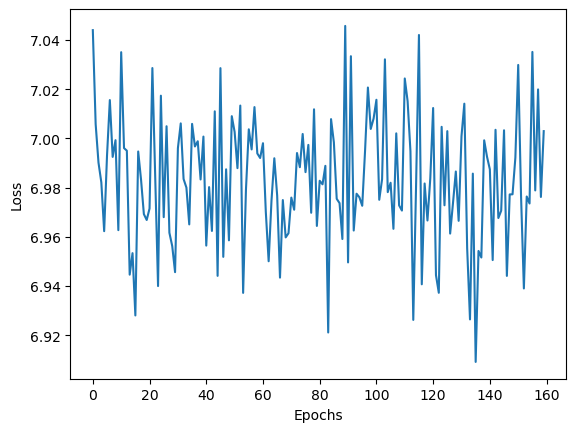

  2%|▌                                    | 161/10000 [03:17<3:20:14,  1.22s/it]

tensor(7.0143, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 162/10000 [03:18<3:07:00,  1.14s/it]

tensor(6.9769, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 163/10000 [03:19<3:09:53,  1.16s/it]

tensor(6.9895, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 164/10000 [03:21<3:16:36,  1.20s/it]

tensor(6.9674, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 165/10000 [03:22<3:09:10,  1.15s/it]

tensor(7.0041, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 166/10000 [03:23<3:09:33,  1.16s/it]

tensor(6.9805, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 167/10000 [03:24<2:56:48,  1.08s/it]

tensor(6.9810, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▌                                    | 168/10000 [03:25<3:05:58,  1.13s/it]

tensor(6.9840, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 169/10000 [03:26<3:03:22,  1.12s/it]

tensor(6.9936, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 170/10000 [03:27<3:07:18,  1.14s/it]

tensor(6.9687, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 171/10000, Loss: 6.964964995198347


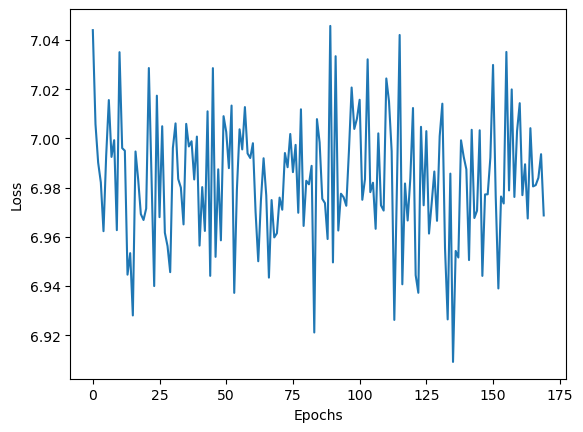

  2%|▋                                    | 171/10000 [03:29<3:21:52,  1.23s/it]

tensor(6.9650, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 172/10000 [03:30<3:15:32,  1.19s/it]

tensor(6.9547, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 173/10000 [03:31<3:15:44,  1.20s/it]

tensor(6.9373, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 174/10000 [03:32<3:11:04,  1.17s/it]

tensor(6.9844, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 175/10000 [03:33<3:09:05,  1.15s/it]

tensor(6.9793, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 176/10000 [03:34<2:58:29,  1.09s/it]

tensor(7.0109, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 177/10000 [03:35<3:02:52,  1.12s/it]

tensor(6.9645, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 178/10000 [03:37<3:18:18,  1.21s/it]

tensor(6.9883, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 179/10000 [03:38<3:03:34,  1.12s/it]

tensor(6.9746, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 180/10000 [03:39<3:06:10,  1.14s/it]

tensor(6.9678, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 181/10000, Loss: 6.992038563100998


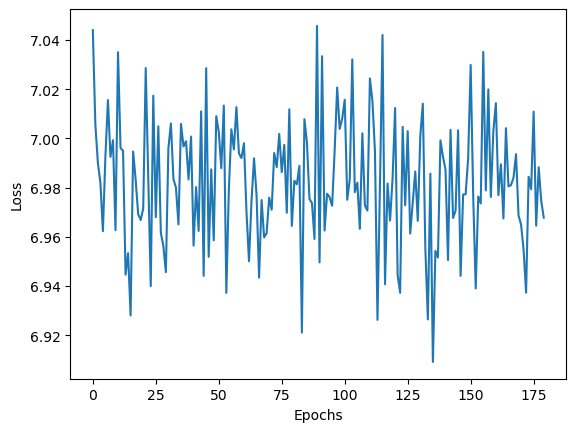

  2%|▋                                    | 181/10000 [03:40<3:02:43,  1.12s/it]

tensor(6.9920, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 182/10000 [03:41<3:13:32,  1.18s/it]

tensor(7.0351, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 183/10000 [03:42<3:02:41,  1.12s/it]

tensor(6.9935, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 184/10000 [03:44<3:06:53,  1.14s/it]

tensor(7.0014, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 185/10000 [03:45<3:21:43,  1.23s/it]

tensor(6.9774, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 186/10000 [03:46<3:04:24,  1.13s/it]

tensor(6.9783, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 187/10000 [03:47<3:06:36,  1.14s/it]

tensor(6.9867, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 188/10000 [03:48<3:08:05,  1.15s/it]

tensor(6.9617, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 189/10000 [03:49<3:07:04,  1.14s/it]

tensor(6.9947, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 190/10000 [03:50<3:05:47,  1.14s/it]

tensor(6.9705, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 191/10000, Loss: 6.940056244668181


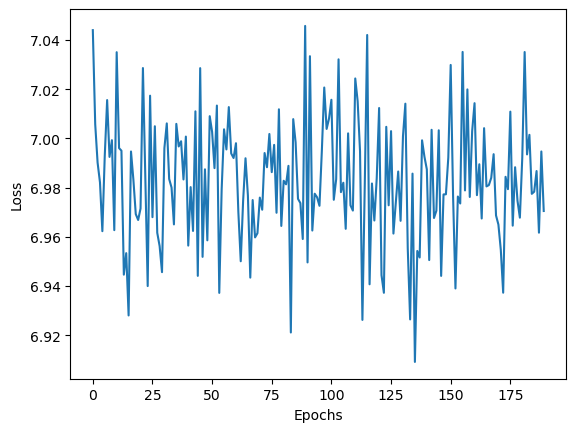

  2%|▋                                    | 191/10000 [03:52<3:13:48,  1.19s/it]

tensor(6.9401, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 192/10000 [03:53<3:27:40,  1.27s/it]

tensor(6.9292, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 193/10000 [03:54<3:08:20,  1.15s/it]

tensor(6.9930, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 194/10000 [03:55<3:08:44,  1.15s/it]

tensor(7.0232, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 195/10000 [03:56<2:58:03,  1.09s/it]

tensor(6.9506, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 196/10000 [03:57<2:59:23,  1.10s/it]

tensor(7.0096, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 197/10000 [03:59<3:04:18,  1.13s/it]

tensor(6.9792, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 198/10000 [04:00<3:08:02,  1.15s/it]

tensor(6.9483, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 199/10000 [04:01<3:10:42,  1.17s/it]

tensor(6.9554, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 200/10000 [04:02<2:57:05,  1.08s/it]

tensor(7.0168, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 201/10000, Loss: 7.006444975837549


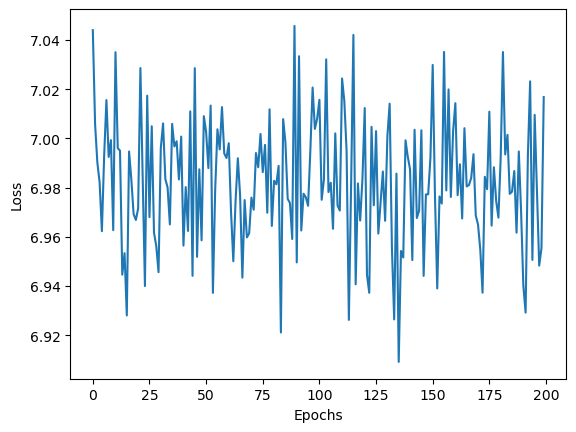

tensor(7.0064, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▋                                    | 202/10000 [04:04<3:12:44,  1.18s/it]

tensor(7.0051, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 203/10000 [04:06<3:13:11,  1.18s/it]

tensor(6.9824, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 204/10000 [04:06<2:58:50,  1.10s/it]

tensor(7.0183, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 205/10000 [04:08<3:04:35,  1.13s/it]

tensor(6.9873, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 206/10000 [04:09<3:11:06,  1.17s/it]

tensor(7.0052, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 207/10000 [04:10<3:07:47,  1.15s/it]

tensor(6.9784, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 208/10000 [04:11<3:06:36,  1.14s/it]

tensor(6.9968, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 209/10000 [04:12<2:56:56,  1.08s/it]

tensor(6.9720, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 210/10000 [04:13<3:02:13,  1.12s/it]

tensor(7.0259, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 211/10000, Loss: 6.9606409254968895


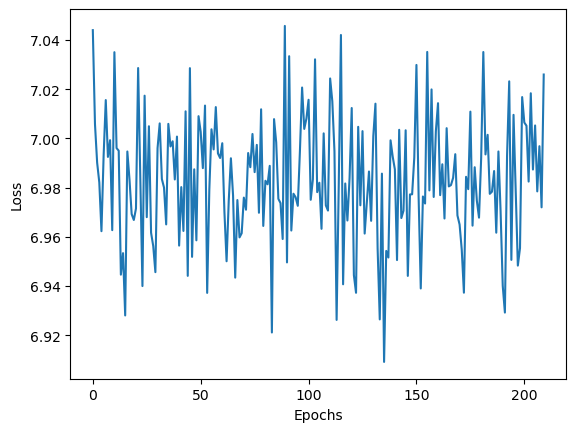

  2%|▊                                    | 211/10000 [04:15<3:17:05,  1.21s/it]

tensor(6.9606, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 212/10000 [04:16<3:06:26,  1.14s/it]

tensor(6.9927, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 213/10000 [04:17<3:08:20,  1.15s/it]

tensor(6.9492, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 214/10000 [04:18<2:56:58,  1.09s/it]

tensor(6.9811, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 215/10000 [04:19<3:01:34,  1.11s/it]

tensor(7.0471, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 216/10000 [04:20<3:12:39,  1.18s/it]

tensor(7.0299, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 217/10000 [04:22<3:13:55,  1.19s/it]

tensor(6.9992, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 218/10000 [04:23<3:25:07,  1.26s/it]

tensor(6.9834, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 219/10000 [04:24<3:06:34,  1.14s/it]

tensor(6.9738, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 220/10000 [04:25<3:07:10,  1.15s/it]

tensor(6.9949, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 221/10000, Loss: 6.972068210037415


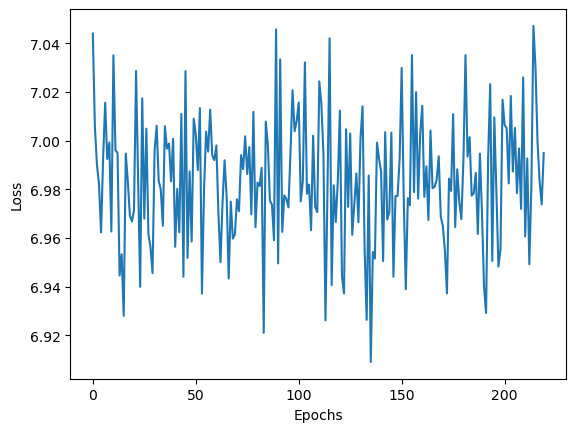

  2%|▊                                    | 221/10000 [04:26<3:02:14,  1.12s/it]

tensor(6.9721, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 222/10000 [04:27<3:15:15,  1.20s/it]

tensor(6.9778, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 223/10000 [04:28<3:02:10,  1.12s/it]

tensor(6.9997, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 224/10000 [04:30<3:06:31,  1.14s/it]

tensor(7.0035, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 225/10000 [04:31<3:22:05,  1.24s/it]

tensor(6.9405, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 226/10000 [04:32<3:04:59,  1.14s/it]

tensor(6.9871, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 227/10000 [04:33<3:07:14,  1.15s/it]

tensor(7.0263, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 228/10000 [04:34<2:56:32,  1.08s/it]

tensor(6.9824, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 229/10000 [04:36<3:17:35,  1.21s/it]

tensor(6.9277, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 230/10000 [04:37<3:07:10,  1.15s/it]

tensor(6.9875, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 231/10000, Loss: 6.985313292762633


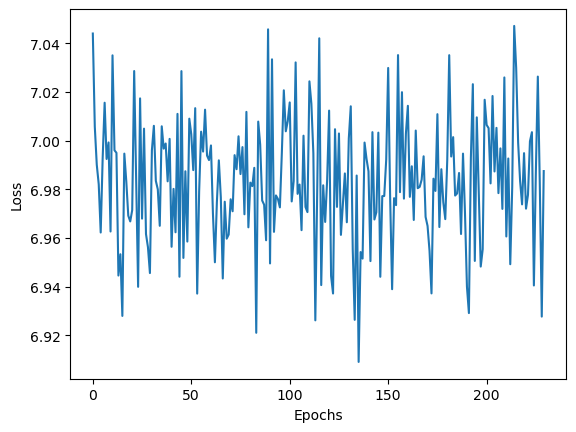

  2%|▊                                    | 231/10000 [04:38<3:15:43,  1.20s/it]

tensor(6.9853, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 232/10000 [04:39<3:12:52,  1.18s/it]

tensor(6.9702, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 233/10000 [04:40<3:14:04,  1.19s/it]

tensor(6.9839, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 234/10000 [04:41<3:14:32,  1.20s/it]

tensor(6.9848, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 235/10000 [04:42<3:03:10,  1.13s/it]

tensor(6.9881, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▊                                    | 236/10000 [04:44<3:12:23,  1.18s/it]

tensor(6.9951, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▉                                    | 237/10000 [04:45<3:01:18,  1.11s/it]

tensor(6.9370, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▉                                    | 238/10000 [04:46<3:05:48,  1.14s/it]

tensor(7.0078, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▉                                    | 239/10000 [04:47<3:09:30,  1.16s/it]

tensor(6.9699, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▉                                    | 240/10000 [04:48<2:59:07,  1.10s/it]

tensor(6.9703, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 241/10000, Loss: 6.990139055993149


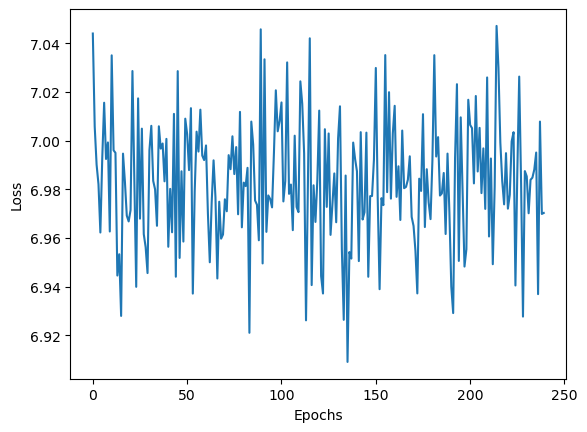

  2%|▉                                    | 241/10000 [04:49<3:04:26,  1.13s/it]

tensor(6.9901, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▉                                    | 242/10000 [04:50<3:01:27,  1.12s/it]

tensor(6.9839, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▉                                    | 243/10000 [04:52<3:19:45,  1.23s/it]

tensor(6.9867, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▉                                    | 244/10000 [04:53<3:16:11,  1.21s/it]

tensor(6.9710, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▉                                    | 245/10000 [04:54<3:13:38,  1.19s/it]

tensor(7.0013, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▉                                    | 246/10000 [04:55<3:12:02,  1.18s/it]

tensor(6.9277, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▉                                    | 247/10000 [04:56<2:55:38,  1.08s/it]

tensor(7.0063, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▉                                    | 248/10000 [04:57<2:59:12,  1.10s/it]

tensor(6.9642, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▉                                    | 249/10000 [04:58<2:48:56,  1.04s/it]

tensor(6.9746, dtype=torch.float64, grad_fn=<AddBackward0>)


  2%|▉                                    | 250/10000 [04:59<3:00:06,  1.11s/it]

tensor(7.0112, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 251/10000, Loss: 6.973470727718792


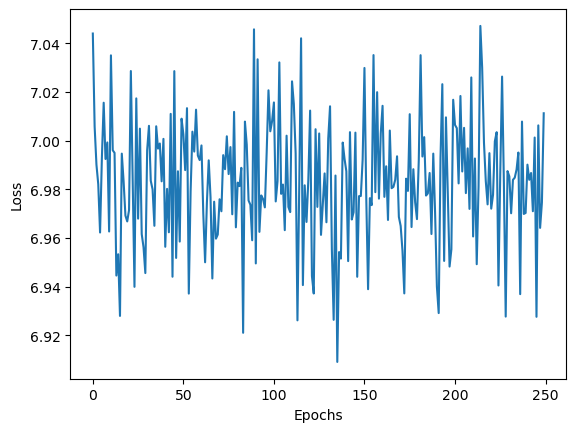

  3%|▉                                    | 251/10000 [05:01<3:03:28,  1.13s/it]

tensor(6.9735, dtype=torch.float64, grad_fn=<AddBackward0>)


  3%|▉                                    | 252/10000 [05:02<3:11:03,  1.18s/it]

tensor(6.9499, dtype=torch.float64, grad_fn=<AddBackward0>)


  3%|▉                                    | 253/10000 [05:04<3:50:01,  1.42s/it]

tensor(7.0106, dtype=torch.float64, grad_fn=<AddBackward0>)


  3%|▉                                    | 254/10000 [05:06<3:59:15,  1.47s/it]

tensor(7.0150, dtype=torch.float64, grad_fn=<AddBackward0>)


  3%|▉                                    | 255/10000 [05:07<4:00:36,  1.48s/it]

tensor(6.9771, dtype=torch.float64, grad_fn=<AddBackward0>)


  3%|▉                                    | 256/10000 [05:09<4:26:31,  1.64s/it]

tensor(7.0108, dtype=torch.float64, grad_fn=<AddBackward0>)


  3%|▉                                    | 257/10000 [05:10<4:13:24,  1.56s/it]

tensor(7.0403, dtype=torch.float64, grad_fn=<AddBackward0>)


In [13]:
model.train(X, y, task_lengths, 10000)

In [ ]:
test = pd.DataFrame()
for name in os.listdir("../datasets/mw_valid"):
    if not (name.startswith('.')):
        dir_name = 'mw_valid/'+name
        print(dir_name)
        df = read_file(dir_name)
        test = pd.concat([data, df])

test.reset_index(drop=True, inplace=True)
Test = PreferenceMAML(test, input_size, hidden_size1, hidden_size2, output_size)
test_X, test_y = Test.prepare_data(k=4)


# Evaluate the model on the test set
def evaluate_model(model, X, y):
    predictions = []
    with torch.no_grad():
        for i in range(len(X)):
            X_tensor = torch.tensor(X[i], dtype=torch.float32)
            output = model.model(X_tensor.unsqueeze(0))  
            predictions.append(output.squeeze().numpy())  

    preds = []
    for _ in range(len(predictions)):
        preds.append((np.array(predictions[_]).mean()))

    pred_label = []
    for i in range(len(preds)):
        pred_label.append([0] if preds[i]>0.5 else [1])
    
    sum = 0
    for _ in range(len(y)):
        sum += pred_label[_]==y[_]
    accuracy = sum/len(y)
    return accuracy, pred_label

test_accuracy, pred_labels = evaluate_model(model, test_X, test_y)
print(f'\nTest Accuracy: {test_accuracy}')

mw_valid/cls_lever-pull-v2


TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

### Without INNER LOOP

In [ ]:
# import itertools
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import pandas as pd

# class Model(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(Model, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc3 = nn.Linear(hidden_size2, output_size)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x


# class PreferenceMAML:
#     def __init__(
#         self,
#         ml10,
#         input_size,
#         hidden_size1,
#         hidden_size2,
#         output_size,
#         num_support=10,
#         num_query=10,
#         num_inner_steps=5,
#         **kwargs,
#     ):
#         self.ml10 = ml10
#         self.reward_criterion =  nn.CrossEntropyLoss()
#         self.num_support = num_support
#         self.num_query = num_query
#         self.num_inner_steps = num_inner_steps

#         self.model = Model(input_size, hidden_size1, hidden_size2, output_size)

#     def construct_episodes(self):
#         episodes = []
#         episode = []
#         for _, row in self.ml10.iterrows():
#             episode.append(row)
#             if row['done']:
#                 episodes.append(episode)
#                 episode = []
#         return episodes



#     def form_sigma_groups(self, episode, k):
#         sigmas = []
#         segments = []
#         q, r = divmod(len(episode), k)
#         for i in range(k):
#             segments.append(episode[i*q+min(i,r) : (i+1)*q+min(i+1,r)])

#         for i in range(k):
#             sigma_i = segments[i]
#             for j in range(i+1, k):
#                 sigma_j = segments[j]

#                 sigmas.append((sigma_i, sigma_j))
#         return sigmas

#     def compare_probabilities(self, sigma1, sigma2):
#         exp_sum_rewards_sigma1 = np.exp(sum(row['reward'] for row in sigma1))
#         exp_sum_rewards_sigma2 = np.exp(sum(row['reward'] for row in sigma2))
#         prob = exp_sum_rewards_sigma1 / (exp_sum_rewards_sigma1 + exp_sum_rewards_sigma2)
#         return [1,0] if prob > 0.5 else [0,1]


#     def prepare_data(self, k):
#         X = []
#         y = []
#         episodes = self.construct_episodes()
#         for episode in episodes:
#             sigmas = self.form_sigma_groups(episode, k)
#             for _ in range(len(sigmas)):

#                 sigma1 = sigmas[_][0]
#                 sigma2 = sigmas[_][1]

#                 obs_action_sigma1 = []
#                 for row in sigma1:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma1.append(obs_action)

#                 obs_action_sigma2 = []
#                 for row in sigma2:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma2.append(obs_action)

#                 if len(obs_action_sigma1) > len(obs_action_sigma2):
#                     obs_action_sigma1 = obs_action_sigma1[1:]
#                 elif len(obs_action_sigma1) < len(obs_action_sigma2):
#                     obs_action_sigma2 = obs_action_sigma2[1:]
#                 else:
#                     continue

#                 X.append(np.concatenate((obs_action_sigma1, obs_action_sigma2), axis = 1))
#                 y.append([self.compare_probabilities(sigma1, sigma2)]) 

#         return X, y


#     def setup_optimizers(self, optim_class, optim_kwargs):
#         self.optim = optim_class(self.model.parameters(), **optim_kwargs)

#     def _train_step(self, X, y):
#         self.optim.zero_grad()
#         loss = self._outer_step(X, y)
#         loss.backward()
#         self.optim.step()
#         return loss.item()

#     def _outer_step(self, X, y):
#         outer_losses = []
#         for i in range(len(X)):
#             loss = self._compute_loss(X[i], y[i])
#             outer_losses.append(loss)
#         return torch.mean(torch.stack(outer_losses))

#     def _compute_loss(self, X, y):
#         X_tensor = torch.tensor(X, dtype=torch.float32)
#         y_tensor = torch.tensor([y], dtype=torch.float32)
#         output = self.model(X_tensor)
#         output_flat = output.view(-1)
#         y_flat = y_tensor.view(-1)
#         loss = self.reward_criterion(output_flat[-2:], y_flat)
#         return loss

# ml10 = data.copy()  
# input_size = 86  # Assuming obs has 39 numbers and action has 4 numbers * 2 for pair of sigmas
# hidden_size1 = 128
# hidden_size2 = 128
# output_size = 2
# num_epochs = 20

# model = PreferenceMAML(ml10, input_size, hidden_size1, hidden_size2, output_size)
# model.setup_optimizers(optim.Adam, {"lr": 0.005})

# X, y = model.prepare_data(k=4)

# # Train the model
# for epoch in range(num_epochs):
#     loss = model._train_step(X, y)
#     print(f"Epoch {epoch+1}, Loss: {loss}")


### With INNER LOOP but Improper classification

In [ ]:
# import itertools
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import pandas as pd
# from tqdm import tqdm
# import warnings
# warnings.filterwarnings('ignore')

# class Model(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(Model, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc3 = nn.Linear(hidden_size2, output_size)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x


# class PreferenceMAML:
#     def __init__(
#         self,
#         ml10,
#         input_size,
#         hidden_size1,
#         hidden_size2,
#         output_size,
#         inner_lr = 0.01,
#         num_support=10,
#         num_query=10,
#         num_inner_steps=5,
#         **kwargs,
#     ):
#         self.ml10 = ml10
#         self.reward_criterion =  nn.CrossEntropyLoss()
#         self.num_support = num_support
#         self.num_query = num_query
#         self.num_inner_steps = num_inner_steps
#         self.inner_lr = inner_lr

#         self.model = Model(input_size, hidden_size1, hidden_size2, output_size)

#     def construct_episodes(self):
#         episodes = []
#         episode = []
#         for _, row in self.ml10.iterrows():
#             episode.append(row)
#             if row['done']:
#                 episodes.append(episode)
#                 episode = []
#         return episodes

#     def form_sigma_groups(self, episode, k):
#         sigmas = []
#         segments = []
#         q, r = divmod(len(episode), k)
#         for i in range(k):
#             segments.append(episode[i*q+min(i,r) : (i+1)*q+min(i+1,r)])

#         for i in range(k):
#             sigma_i = segments[i]
#             for j in range(i+1, k):
#                 sigma_j = segments[j]

#                 sigmas.append((sigma_i, sigma_j))
#         return sigmas

#     def compare_probabilities(self, sigma1, sigma2):
#         exp_sum_rewards_sigma1 = np.exp(sum(row['reward'] for row in sigma1))
#         exp_sum_rewards_sigma2 = np.exp(sum(row['reward'] for row in sigma2))
#         prob = exp_sum_rewards_sigma1 / (exp_sum_rewards_sigma1 + exp_sum_rewards_sigma2)
#         return [1,0] if prob > 0.5 else [0,1]

#     def prepare_data(self, k):
#         X = []
#         y = []
#         episodes = self.construct_episodes()
#         for episode in episodes:
#             sigmas = self.form_sigma_groups(episode, k)
#             for _ in range(len(sigmas)):
#                 sigma1 = sigmas[_][0]
#                 sigma2 = sigmas[_][1]

#                 obs_action_sigma1 = []
#                 for row in sigma1:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma1.append(obs_action)

#                 obs_action_sigma2 = []
#                 for row in sigma2:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma2.append(obs_action)

#                 if len(obs_action_sigma1) > len(obs_action_sigma2):
#                     obs_action_sigma1 = obs_action_sigma1[1:]
#                 elif len(obs_action_sigma1) < len(obs_action_sigma2):
#                     obs_action_sigma2 = obs_action_sigma2[1:]
#                 else:
#                     continue

#                 X.append(np.concatenate((obs_action_sigma1, obs_action_sigma2), axis=1))
#                 y.append(self.compare_probabilities(sigma1, sigma2))

#         return X, y

#     def setup_optimizers(self, optim_class, optim_kwargs):
#         self.optim = optim_class(self.model.parameters(), **optim_kwargs)

#     def _train_step(self, X, y):
#         self.optim.zero_grad()
#         loss = self._outer_step(X, y)
#         loss.backward()
#         self.optim.step()
#         return loss.item()

#     def _outer_step(self, X, y):
#         outer_losses = []
#         for i in tqdm(range(len(X))):
#             if len(X[i])>self.num_support:
#                 support_X, support_y, query_X, query_y = self._split_support_query(X[i], y[i])
#                 # Inner loop (adaptation)
#                 adapted_model = self._inner_loop(support_X, support_y)
#                 # Compute loss using the adapted model on query set
#                 query_loss = self._compute_loss(adapted_model, query_X, query_y)
#                 outer_losses.append(query_loss)
#         return torch.mean(torch.stack(outer_losses))

#     def _inner_loop(self, support_X, support_y):
#         adapted_model = Model(self.model.fc1.in_features, self.model.fc1.out_features,
#                               self.model.fc2.out_features, self.model.fc3.out_features)
#         adapted_model.load_state_dict(self.model.state_dict())

#         inner_optimizer = optim.Adam(adapted_model.parameters(), lr=self.inner_lr)

#         for _ in range(self.num_inner_steps):
#             inner_optimizer.zero_grad()
#             loss = self._compute_loss(adapted_model, support_X, support_y)
#             print(loss)
#             loss.backward()
#             inner_optimizer.step()

#         return adapted_model

#     def _compute_loss(self, model, X, y):
#         X_tensor = torch.tensor(X, dtype=torch.float32)
#         y_class = [0 if y[i]==[1,0] else 1 for i in range(len(y))]
#         y_tensor = torch.tensor(y_class, dtype=torch.long)  # Assuming y is class indices
#         output = model(X_tensor)

#         loss = self.reward_criterion(output, y_tensor)
#         return loss

#     def _split_support_query(self, X, y):
#         num_samples = len(X)
#         all_indices = np.arange(num_samples)
#         # Randomly sample support indices
#         support_indices = np.random.choice(num_samples, self.num_support, replace=False)
#         query_indices = np.setdiff1d(all_indices, support_indices)
#         support_X = X[support_indices]
#         query_X = X[query_indices]
#         # For y, we can simply use the same indices as for X, as it has a fixed length of 2
#         support_y = [y] * self.num_support
#         query_y = [y] * len(query_indices)

#         return support_X, support_y, query_X, query_y


# ml10 = data.copy()  
# input_size = 86  # Assuming obs has 39 numbers and action has 4 numbers * 2 for pair of sigmas
# hidden_size1 = 128
# hidden_size2 = 128
# output_size = 2
# num_epochs = 5
# outer_lr = 0.001

# model = PreferenceMAML(ml10, input_size, hidden_size1, hidden_size2, output_size)
# model.setup_optimizers(optim.Adam, {"lr": outer_lr})

# print('Preparing Data.')
# # X, y = model.prepare_data(k=4)
# print('Data Preparation Done.\n')

# # Train the model
# for epoch in range(num_epochs):
#     print(f'\nBeginning Training - Epoch [{epoch+1}/{num_epochs}]')
#     loss = model._train_step(X, y)
#     print(f"Epoch {epoch+1}, Loss: {loss}")
